In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from statsmodels.stats.weightstats import _zconfint_generic
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_excel("dataset.xls", index_col=0, parse_dates=True)
data.head()

,Tesla,MSCI ACWI,S&P 600 tech,BEST_TARGET_PRICE,Brent,Consumer Comfort Index,Investor Confidence Index,Nominal GDP USA,China's Industrial production index
month,,,,,,,,,
2011-10-01,0.204182,0.103781,0.191402,0.382353,-0.105268,0.000000,-0.075551,0.016110,0.138
2011-11-01,0.114743,-0.073821,0.004412,0.000000,0.066174,-0.035714,-0.036322,-0.001160,0.132
2011-12-01,-0.127673,-0.017958,-0.001160,0.092213,0.008762,0.037037,0.123675,-0.000389,0.124
2012-01-01,0.017857,0.123914,0.091682,-0.035727,-0.028411,0.000000,0.080713,0.006627,0.128
2012-02-01,0.149295,0.072363,0.011742,0.000000,0.033526,0.035714,-0.128031,0.017421,0.121


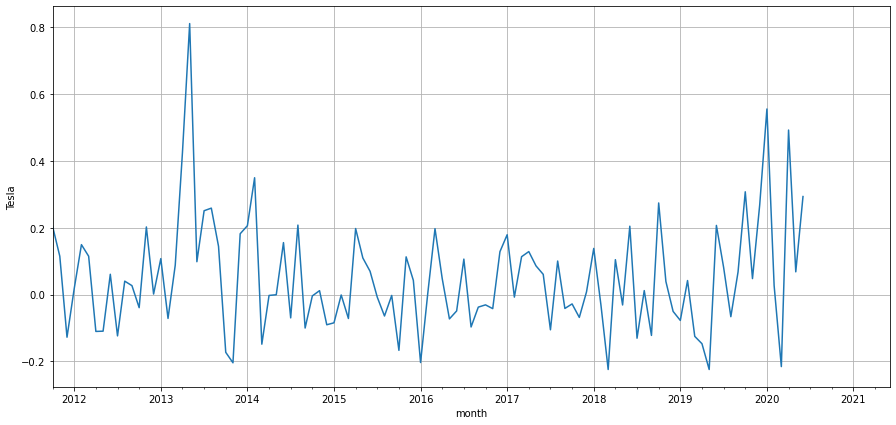

In [3]:
plt.figure(figsize(15,7))
data.Tesla.plot()
plt.ylabel("Tesla")
plt.grid(True)
pylab.show()

In [4]:
for i in data.drop("Tesla", axis=1).columns:
    print("Критерий Дики-Фуллера для {}".format(i)+": p=%f" % sm.tsa.stattools.adfuller(data[i])[1])
print("Критерий Дики-Фуллера для Tesla"+": p=%f" % sm.tsa.stattools.adfuller(data.Tesla[:-12])[1])

Критерий Дики-Фуллера для MSCI ACWI: p=0.000000
Критерий Дики-Фуллера для S&P 600 tech: p=0.000000
Критерий Дики-Фуллера для BEST_TARGET_PRICE: p=0.000000
Критерий Дики-Фуллера для Brent: p=0.000000
Критерий Дики-Фуллера для Consumer Comfort Index: p=0.000000
Критерий Дики-Фуллера для  Investor Confidence Index : p=0.000000
Критерий Дики-Фуллера для Nominal GDP USA: p=0.000000
Критерий Дики-Фуллера для China's Industrial production index: p=0.621690
Критерий Дики-Фуллера для Tesla: p=0.000000


<Figure size 1080x720 with 0 Axes>

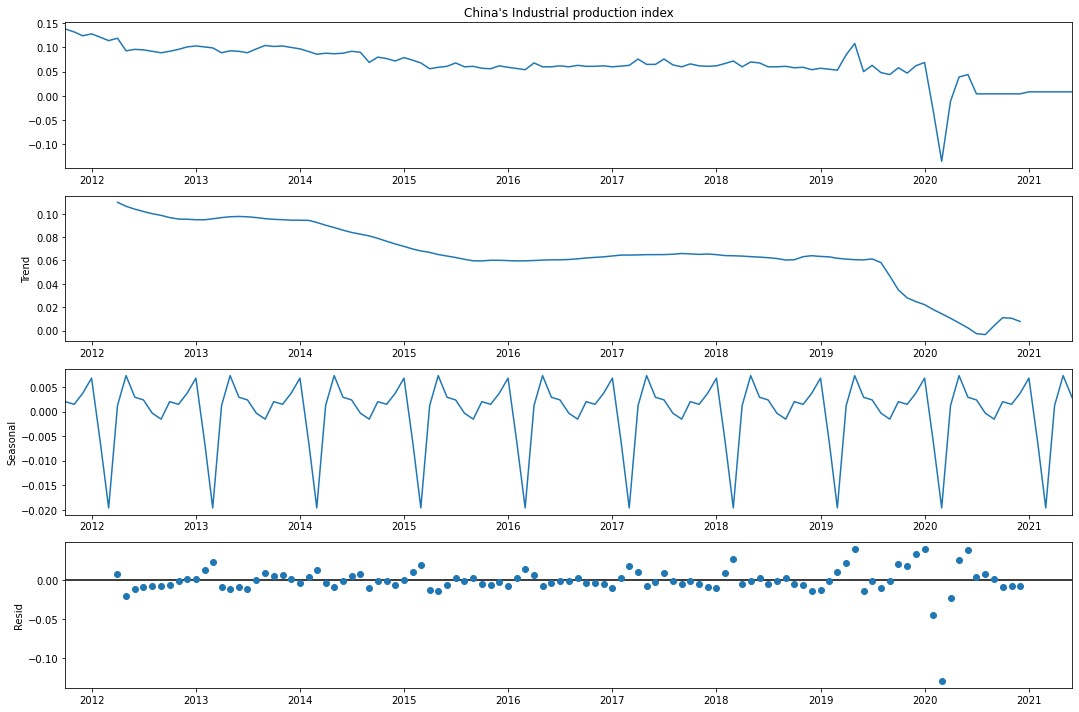

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data["China's Industrial production index"]).plot()
pylab.show()

<Figure size 1080x720 with 0 Axes>

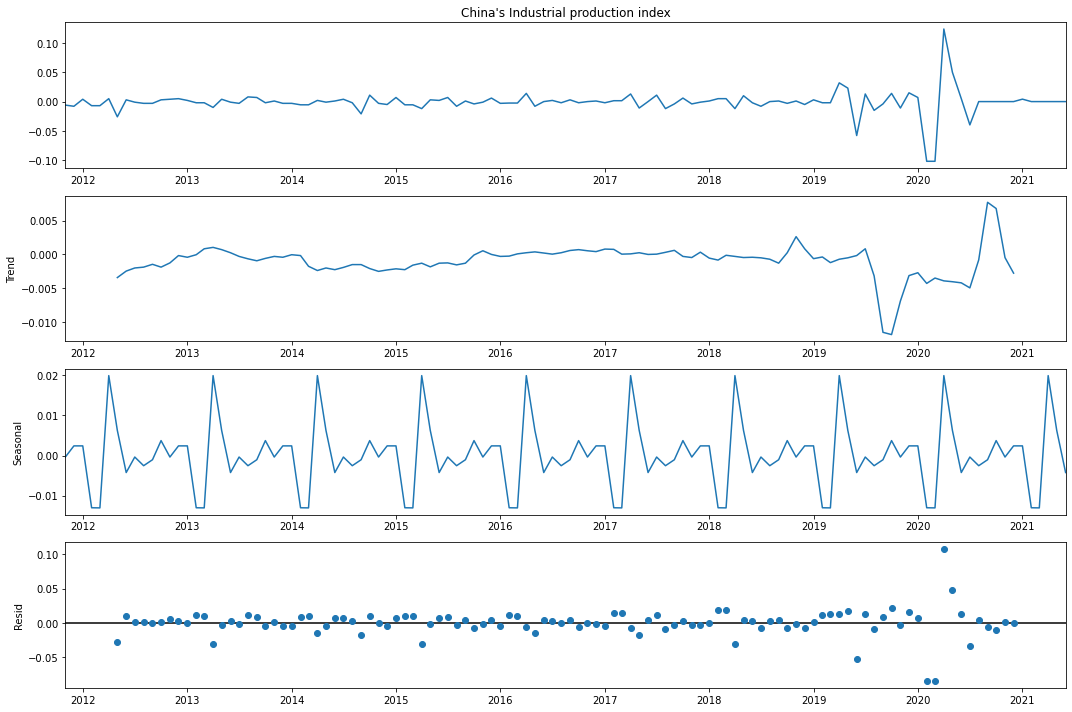

Критерий Дики-Фуллера: p=0.000000


In [6]:
data["China's Industrial production index"] = (data["China's Industrial production index"] 
                                                  - data["China's Industrial production index"].shift(1))
data.drop(data.index[0], inplace=True)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data["China's Industrial production index"]).plot()
pylab.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data["China's Industrial production index"])[1])

In [7]:
X_train = data[:-12].drop("Tesla", axis=1)
y_train = data[:-12]["Tesla"]
X_test = data[-12:].drop("Tesla", axis=1)

price = pd.DataFrame(y_train)

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

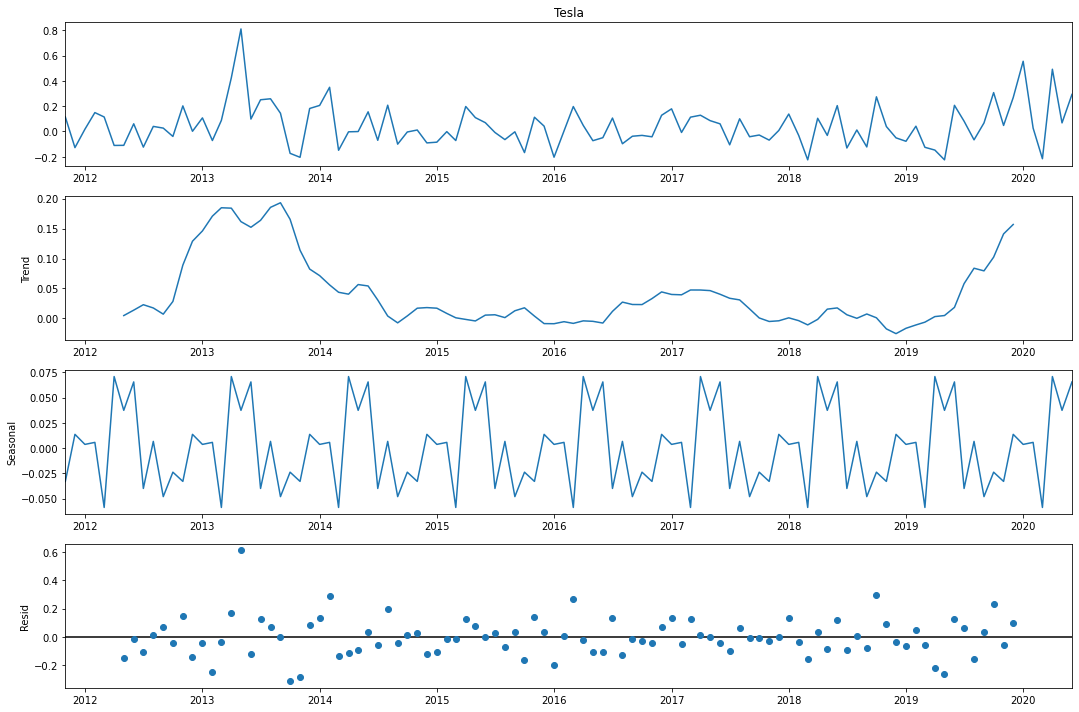

In [8]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(price.Tesla).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(price.Tesla)[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

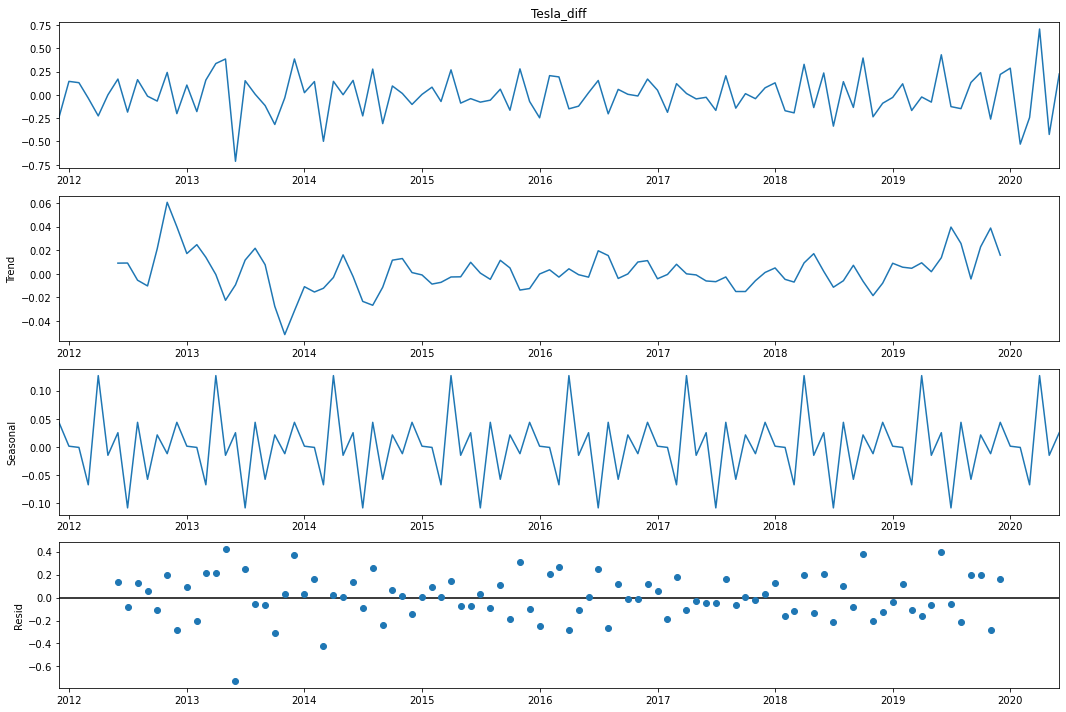

In [9]:
price['Tesla_diff'] = price.Tesla - price.Tesla.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(price.Tesla_diff[1:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(price.Tesla_diff[1:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

## Подбор модели

Посмотрим ACF и PACF полученного ряда:

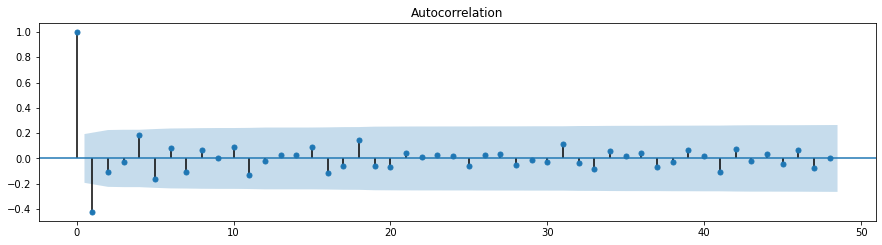

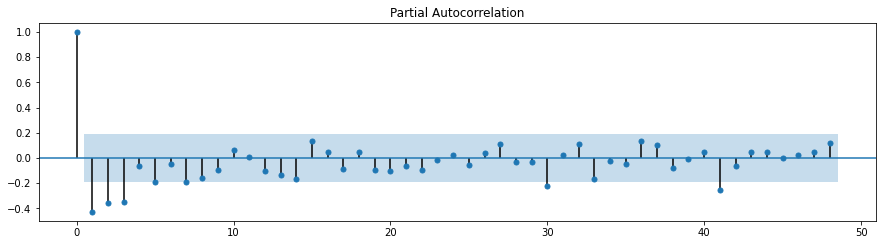

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(price.Tesla_diff[1:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(price.Tesla_diff[1:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=0, p=3

In [11]:
ps = range(4)
d = 1
qs = range(2)
Ps = range(1)
D = 0
Qs = range(1)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(y_train, X_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=True)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings("default")

CPU times: user 11.1 s, sys: 749 ms, total: 11.8 s
Wall time: 3.36 s


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by = "aic", ascending=True).head())

     parameters        aic
3  (1, 1, 0, 0) -74.511003
5  (2, 1, 0, 0) -73.611273
1  (0, 1, 0, 0) -72.489763
7  (3, 1, 0, 0) -71.658000
6  (3, 0, 0, 0) -66.055602


Лучшая модель:

In [15]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Tesla   No. Observations:                  104
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  48.256
Date:                Fri, 21 Aug 2020   AIC                            -74.511
Time:                        10:14:11   BIC                            -45.529
Sample:                    11-01-2011   HQIC                           -62.772
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
MSCI ACWI                               0.8787      0.475      1.850      0.064      -0.052       1.809
S&P 600 tech                            0.2673      0.44

Как можно заметить, что почти все регрессоры, кроме MSCI ACWI, статистически незначимы при заданном уровне значимости 0.1. Переобучим модель, оставив в качестве регроссара только его. 

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(y_train, X_train["MSCI ACWI"], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=True)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings("default")

CPU times: user 5.87 s, sys: 460 ms, total: 6.33 s
Wall time: 1.32 s


In [17]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Tesla   No. Observations:                  104
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  44.657
Date:                Fri, 21 Aug 2020   AIC                            -81.314
Time:                        10:14:12   BIC                            -70.776
Sample:                    11-01-2011   HQIC                           -77.046
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MSCI ACWI      1.1810      0.260      4.538      0.000       0.671       1.691
ar.L1          0.2125      0.110      1.934      0.053      -0.003       0.428
ma.L1         -0.9995      1.621     -0.616      0.5

Её остатки:

Критерий Стьюдента: p=0.936826
Критерий Дики-Фуллера: p=0.000000


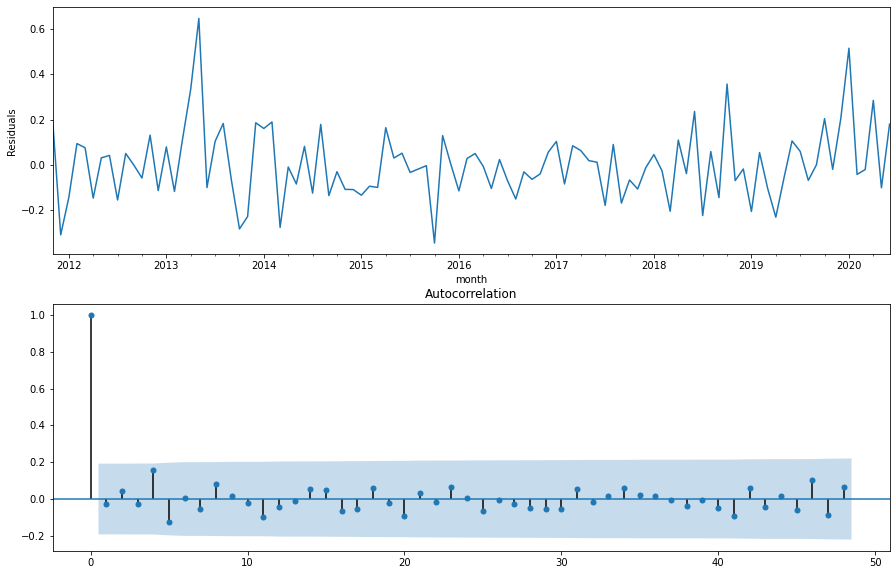

In [18]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

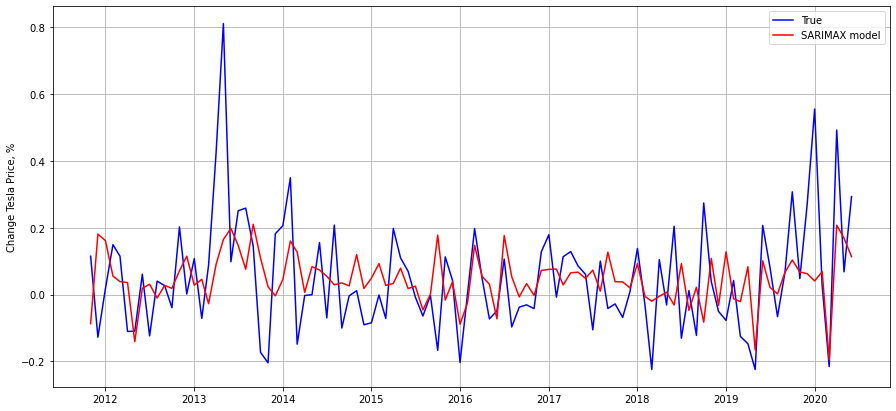

In [19]:
SARIMAX_prediction = best_model.fittedvalues
plt.figure(figsize(15,7))
plt.plot(y_train, color='b', label="True")
plt.plot(SARIMAX_prediction, color='r', label="SARIMAX model")
plt.ylabel("Change Tesla Price, %")
plt.legend()
plt.grid(True)

### Прогноз

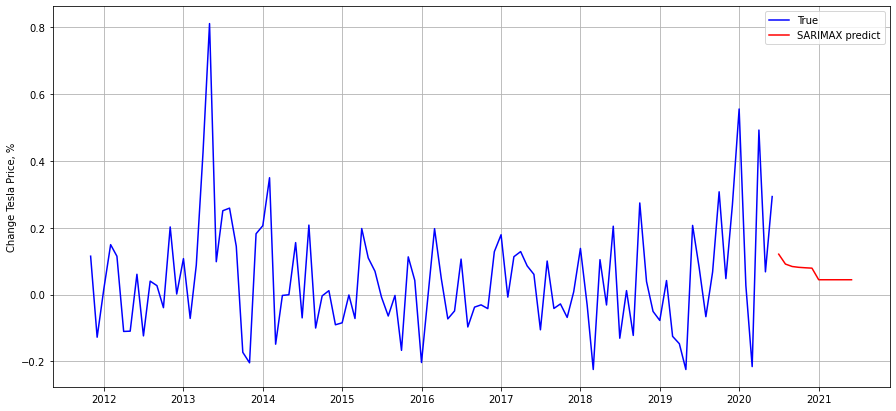

In [20]:
pred_res = best_model.get_prediction(exog=X_test["MSCI ACWI"], start=len(y_train), 
                                     end=len(y_train)+11,full_results=True, alpha=0.05)

future_prediction = pred_res.predicted_mean

plt.figure(figsize(15,7))
plt.plot(y_train, color='b', label="True")
plt.plot(future_prediction, color='r', label="SARIMAX predict")
plt.ylabel("Change Tesla Price, %")
plt.legend()
plt.grid(True)

In [21]:
alfa = 2*(0.01/2)**(1/6)
confidence_interval = pred_res.conf_int(alpha=alfa)

confidence_interval["Tesla"] = future_prediction
absolute_value = (confidence_interval+1)[:6]
absolute_value.loc[y_train.index[len(y_train)-1]] = 1079.81
absolute_value = absolute_value.sort_index()

indexes = absolute_value.index
for column in absolute_value.columns:
    for i in range(1, len(indexes)):
        absolute_value[column][indexes[i]] = (absolute_value[column][indexes[i]]
                                                     *absolute_value[column][indexes[i-1]])

In [22]:
absolute_value

,lower Tesla,upper Tesla,Tesla
2020-06-01,1079.810000,1079.810000,1079.810000
2020-07-01,1173.851524,1246.707229,1210.279376
2020-08-01,1240.318748,1403.460177,1320.630692
2020-09-01,1301.465555,1569.785583,1431.438357
2020-10-01,1362.420201,1751.971206,1548.024028
2020-11-01,1424.347188,1952.883208,1671.967615
2020-12-01,1487.519140,2174.683678,1803.992375


Прогноз на 2020-12-01: 1803.99
Позитивный прогноз на 2020-12-01: 2174.68
Негативный прогноз на 2020-12-01: 1487.52


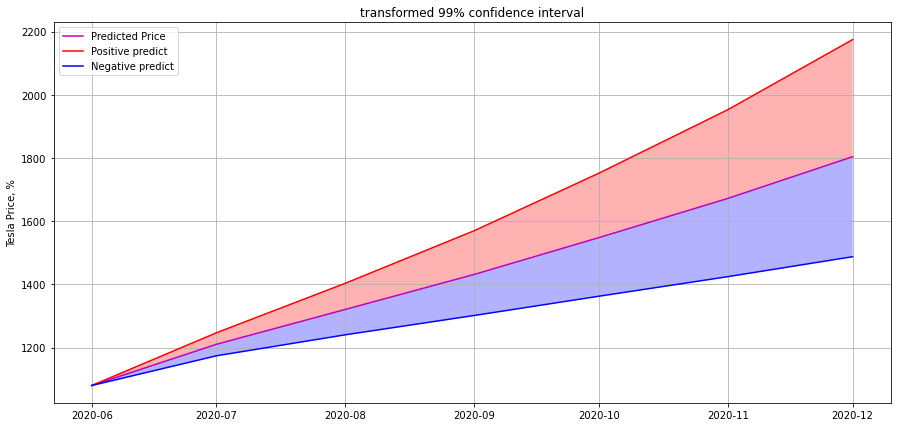

In [23]:
plt.figure(figsize(15,7))
plt.plot(absolute_value["Tesla"], 'm', label="Predicted Price")
plt.plot(absolute_value["upper Tesla"],'r', label="Positive predict")
plt.plot(absolute_value["lower Tesla"],'b', label="Negative predict")
plt.fill_between(absolute_value.index, absolute_value["upper Tesla"], 
                 absolute_value["Tesla"], facecolor='r', alpha=0.3)
plt.fill_between(absolute_value.index, absolute_value["lower Tesla"], 
                 absolute_value["Tesla"], facecolor='b', alpha=0.3)
plt.ylabel("Tesla Price, %")
plt.title("transformed 99% confidence interval")
plt.legend()
plt.grid(True)

print("Прогноз на 2020-12-01: %.2f"% absolute_value["Tesla"]["2020-12-01"])
print("Позитивный прогноз на 2020-12-01: %.2f"% absolute_value["upper Tesla"]["2020-12-01"])
print("Негативный прогноз на 2020-12-01: %.2f"% absolute_value["lower Tesla"]["2020-12-01"])